# Classifiers - low vs high complexity - with TFv1
Exploring different classifiers with with the contractive autoencoder. It needs the TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Contractive Autoencoder](#Contractive-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution() # required for the contractive autoencoder
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
# from https://github.com/ageron/handson-ml/blob/master/extra_tensorflow_reproducibility.ipynb
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1)

with tf.compat.v1.Session(config=config) as sess:
    #... this will run single threaded
    pass

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [6]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds, checkIfValid=True):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
#         if cog_res['task_label'][task_num_table] != 'NC':
#             continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            if checkIfValid and not (tmpBR['br_ok'][0]):
                # don't add this to the data that will be returned
                # by going to the next iteration
                continue
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [8]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [9]:
def set_random_seeds():
    # clear session and set seeds again
    # cannot clear session due to tf.compat.v1 graphs, but add tf.compat.v1.set_random_seed
#     K.clear_session()
    tf.compat.v1.set_random_seed(2)
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [10]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [11]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [12]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    
    if (y.shape[0] <= 0):
        idents.remove(ident)
        print(ident)
        continue
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

In [13]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [14]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [15]:
def compare_plot_n(data1, data2, data3, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Contractive Autoencoder
From: https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

In [16]:
# define a function to be able to access the autoencoder in the loss funciton
def loss_with_params(autoencoder):
    # loss function from https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
    def contractive_loss(y_pred, y_true):

        lam = 1e-4
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    return contractive_loss

In [17]:
def contractive_ae(x, encoding_dim=64, encoded_as_model=False):
    # From https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

    input_data = Input(shape=x[0].shape, name="input")
    encoded = Dense(encoding_dim, activation='relu', name='encoded')(input_data)
    outputs = Dense(x[0].shape[0], activation='sigmoid', name="output")(encoded)

    autoencoder = Model(input_data, outputs, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss=loss_with_params(autoencoder), metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [18]:
set_random_seeds()
ct_ae, ct_enc = contractive_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
ct_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Plot signal, reconstruction and encoded representation:

<Figure size 432x288 with 0 Axes>

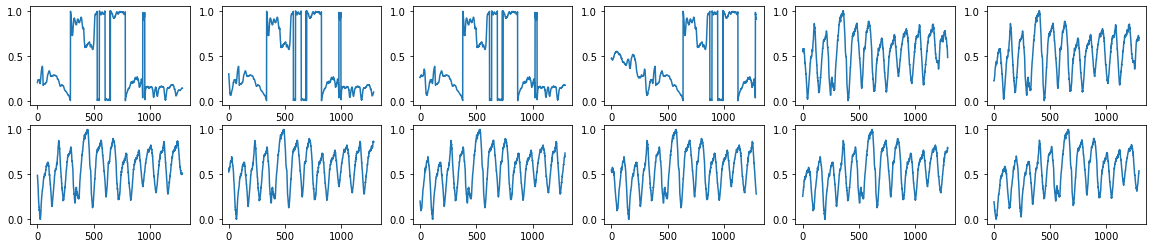

<Figure size 432x288 with 0 Axes>

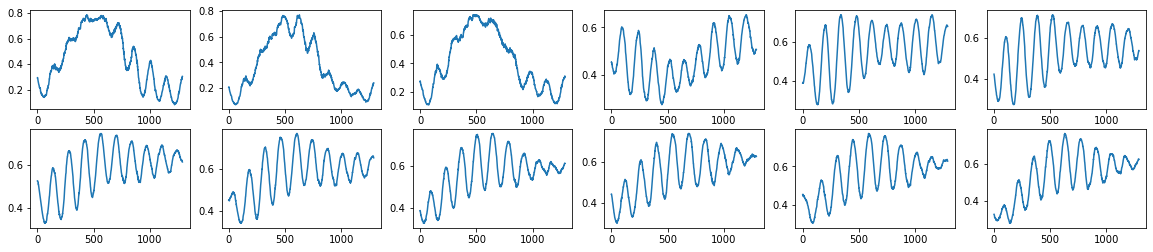

In [19]:
data2 = ct_ae.predict(phase_all_valid)
data3 = ct_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, data3)

Store the encoded representations in the data dictionary:

In [20]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    ct_data = ct_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['contractive_encoded'] = ct_data

Helper function to get data from the dictionary:

In [21]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    contractive_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        y = np.vstack((y, data_dict[tmp_id]['y']))
        contractive_encoded = np.vstack((contractive_encoded, data_dict[tmp_id]['contractive_encoded']))
    
    return y, phase, contractive_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [22]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['contractive'] = []
    accs['test id'] = []
    start_time = datetime.now()

    with tf.compat.v1.Session(config=config) as sess:
        # leave out person out validation
        for i in range(n):

            # print current iteration and time elapsed from start
            print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

            ## ----- Data preparation:
            validation_idents = [idents[i]]
            test_idents = [idents[i-1]]

            train_idents = []
            for ident in idents:
                if (ident not in test_idents) and (ident not in validation_idents):
                    train_idents.append(ident)

            # save test id to see which id yielded which accuracies
            accs['test id'].append(test_idents[0])

            # Load train data
            train_data = get_ident_data_from_dict(train_idents, data_dict)
            y_train = train_data[0]

            # Load validation data
            valid_data = get_ident_data_from_dict(validation_idents, data_dict)
            y_valid = valid_data[0]

            # Load test data
            test_data = get_ident_data_from_dict(test_idents, data_dict)
            y_test = test_data[0]

            data_names_by_index = ['y', 'phase', 'contractive']

            # Loop over all data that will be used for classification and send it to the classifier
            # index 0 is y so we skip it
            for index in range(1, len(test_data)):
                set_random_seeds()
                train_x = train_data[index]
                valid_x = valid_data[index]
                test_x = test_data[index]

                # Scale data
                if should_scale_data:
                    # Scale with standard scaler
                    sscaler = StandardScaler()
                    sscaler.fit(train_x)
                    train_x = sscaler.transform(train_x)

                    # Scale valid and test with train's scaler
                    valid_x = sscaler.transform(valid_x)
                    test_x = sscaler.transform(test_x)
                
                # Initialize variables
                tmp_acc = []
                data_name = data_names_by_index[index]

                for index in range(num_loops_to_average_over):
                    curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                    tmp_acc.append(curr_acc)

                # Store accuracy
                curr_acc = np.mean(tmp_acc)
                accs[data_name].append(curr_acc)


        # Print total time required to run this
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [23]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [24]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [25]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_dense_ae_enc
    if (data_name == 'phase'):
        params = params_dense_phase
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [26]:
accs = helper_loop(dense_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.005984
iteration: 2 of 23 ; time elapsed: 0:00:26.702350
iteration: 3 of 23 ; time elapsed: 0:00:54.586100
iteration: 4 of 23 ; time elapsed: 0:01:23.193151
iteration: 5 of 23 ; time elapsed: 0:01:51.922356
iteration: 6 of 23 ; time elapsed: 0:02:20.290210
iteration: 7 of 23 ; time elapsed: 0:02:48.857222
iteration: 8 of 23 ; time elapsed: 0:03:19.224686
iteration: 9 of 23 ; time elapsed: 0:03:48.506922
iteration: 10 of 23 ; time elapsed: 0:04:19.453083
iteration: 11 of 23 ; time elapsed: 0:04:50.911488
iteration: 12 of 23 ; time elapsed: 0:05:24.395132
iteration: 13 of 23 ; time elapsed: 0:05:55.421146
iteration: 14 of 23 ; time elapsed: 0:06:28.829505
iteration: 15 of 23 ; time elapsed: 0:07:03.243737
iteration: 16 of 23 ; time elapsed: 0:07:34.276419
iteration: 17 of 23 ; time elapsed: 0:08:08.441236
iteration: 18 of 23 ; time elapsed: 0:08:43.625113
iteration: 19 of 23 ; time elapsed: 0:09:21.162566
iteration: 20 of 23 ; time elapsed: 0:09

In [27]:
accuracies['simple_dense'] = accs

In [28]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.204082,0.265306,62i9y
1,0.493827,0.432099,2gu87
2,0.337662,0.428571,iz2ps
3,0.606742,0.426966,1mpau
4,0.380952,0.511905,7dwjy
5,0.533898,0.516949,7swyk
6,0.617647,0.529412,94mnx
7,0.634615,0.653846,bd47a
8,0.490000,0.450000,c24ur
9,0.397260,0.506849,ctsax


In [29]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.204082     0.265306
max     0.860465     0.666667
mean    0.525702     0.508571
median  0.526316     0.506849


#### LSTM-based classifier  
based on the original author's code

In [30]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [31]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [32]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_lstm_ae_enc
    if (data_name == 'phase'):
        params = params_lstm_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [33]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00.007979
iteration: 2 of 23 ; time elapsed: 0:03:13.529092
iteration: 3 of 23 ; time elapsed: 0:06:20.535085
iteration: 4 of 23 ; time elapsed: 0:09:29.558473
iteration: 5 of 23 ; time elapsed: 0:12:42.717911
iteration: 6 of 23 ; time elapsed: 0:15:57.676405
iteration: 7 of 23 ; time elapsed: 0:19:11.342726
iteration: 8 of 23 ; time elapsed: 0:22:32.978759
iteration: 9 of 23 ; time elapsed: 0:25:52.886578
iteration: 10 of 23 ; time elapsed: 0:29:11.666026
iteration: 11 of 23 ; time elapsed: 0:32:32.073312
iteration: 12 of 23 ; time elapsed: 0:35:49.309733
iteration: 13 of 23 ; time elapsed: 0:39:17.322921
iteration: 14 of 23 ; time elapsed: 0:42:57.697051
iteration: 15 of 23 ; time elapsed: 0:46:23.247548
iteration: 16 of 23 ; time elapsed: 0:49:45.684338
iteration: 17 of 23 ; time elapsed: 0:53:12.842836
iteration: 18 of 23 ; time elapsed: 0:56:46.220550
iteration: 19 of 23 ; time elapsed: 1:00:32.707849
iteration: 20 of 23 ; time elapsed: 1:04

In [34]:
accuracies['LSTM'] = accs

In [35]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.591837,0.387755,62i9y
1,0.506173,0.444444,2gu87
2,0.389610,0.363636,iz2ps
3,0.550562,0.595506,1mpau
4,0.476190,0.630952,7dwjy
5,0.559322,0.457627,7swyk
6,0.544118,0.617647,94mnx
7,0.500000,0.500000,bd47a
8,0.380000,0.260000,c24ur
9,0.671233,0.561644,ctsax


In [36]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.345794     0.250000
max     0.797468     0.790698
mean    0.533391     0.535494
median  0.513761     0.543860


#### kNN

In [37]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [38]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [39]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [40]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_ae_enc
    if (data_name == 'phase'):
        params = params_knn_phase
    
    model = KNN_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [41]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.029613
iteration: 2 of 23 ; time elapsed: 0:00:00.188224
iteration: 3 of 23 ; time elapsed: 0:00:00.385812
iteration: 4 of 23 ; time elapsed: 0:00:00.555840
iteration: 5 of 23 ; time elapsed: 0:00:00.724391
iteration: 6 of 23 ; time elapsed: 0:00:00.887983
iteration: 7 of 23 ; time elapsed: 0:00:01.057498
iteration: 8 of 23 ; time elapsed: 0:00:01.227044
iteration: 9 of 23 ; time elapsed: 0:00:01.411118
iteration: 10 of 23 ; time elapsed: 0:00:01.587651
iteration: 11 of 23 ; time elapsed: 0:00:01.764833
iteration: 12 of 23 ; time elapsed: 0:00:01.935719
iteration: 13 of 23 ; time elapsed: 0:00:02.096391
iteration: 14 of 23 ; time elapsed: 0:00:02.256969
iteration: 15 of 23 ; time elapsed: 0:00:02.453407
iteration: 16 of 23 ; time elapsed: 0:00:02.627939
iteration: 17 of 23 ; time elapsed: 0:00:02.788541
iteration: 18 of 23 ; time elapsed: 0:00:02.952102
iteration: 19 of 23 ; time elapsed: 0:00:03.133618
iteration: 20 of 23 ; time elapsed: 0:00

In [42]:
accuracies['kNN'] = accs

In [43]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.326531,0.448980,62i9y
1,0.641975,0.555556,2gu87
2,0.467532,0.376623,iz2ps
3,0.561798,0.617978,1mpau
4,0.440476,0.583333,7dwjy
5,0.483051,0.398305,7swyk
6,0.485294,0.500000,94mnx
7,0.634615,0.596154,bd47a
8,0.600000,0.450000,c24ur
9,0.630137,0.438356,ctsax


In [44]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.326531     0.376623
max     0.755814     0.784810
mean    0.536686     0.552400
median  0.531250     0.581395


####  SVC

In [45]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [46]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [47]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [48]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_ae_enc
    if (data_name == 'phase'):
        params = params_svc_phase
    
    model = SVC_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [49]:
accs = helper_loop(SVC_train, idents, n=n, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00.006981
iteration: 2 of 23 ; time elapsed: 0:00:21.792657
iteration: 3 of 23 ; time elapsed: 0:00:43.207886
iteration: 4 of 23 ; time elapsed: 0:01:04.747193
iteration: 5 of 23 ; time elapsed: 0:01:26.592042
iteration: 6 of 23 ; time elapsed: 0:01:46.853074
iteration: 7 of 23 ; time elapsed: 0:02:07.756533
iteration: 8 of 23 ; time elapsed: 0:02:29.911545
iteration: 9 of 23 ; time elapsed: 0:02:50.792726
iteration: 10 of 23 ; time elapsed: 0:03:12.284881
iteration: 11 of 23 ; time elapsed: 0:03:34.060385
iteration: 12 of 23 ; time elapsed: 0:03:55.902095
iteration: 13 of 23 ; time elapsed: 0:04:18.199403
iteration: 14 of 23 ; time elapsed: 0:04:40.394237
iteration: 15 of 23 ; time elapsed: 0:05:01.646293
iteration: 16 of 23 ; time elapsed: 0:05:22.357739
iteration: 17 of 23 ; time elapsed: 0:05:44.894149
iteration: 18 of 23 ; time elapsed: 0:06:07.622450
iteration: 19 of 23 ; time elapsed: 0:06:29.784404
iteration: 20 of 23 ; time elapsed: 0:06

In [50]:
accuracies['SVC'] = accs

In [51]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.265306,0.408163,62i9y
1,0.493827,0.432099,2gu87
2,0.402597,0.441558,iz2ps
3,0.617978,0.629213,1mpau
4,0.559524,0.619048,7dwjy
5,0.432203,0.584746,7swyk
6,0.602941,0.558824,94mnx
7,0.596154,0.480769,bd47a
8,0.490000,0.440000,c24ur
9,0.493151,0.465753,ctsax


In [52]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.265306     0.408163
max     0.837209     0.758621
mean    0.554563     0.565827
median  0.559524     0.561798


#### Random Forest

In [53]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [54]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [55]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [56]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_ae_enc
    if (data_name == 'phase'):
        params = params_rf_phase
    
    model = random_forest_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [57]:
accs = helper_loop(random_forest_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.006981
iteration: 2 of 23 ; time elapsed: 0:00:18.866267
iteration: 3 of 23 ; time elapsed: 0:00:37.354715
iteration: 4 of 23 ; time elapsed: 0:00:55.487841
iteration: 5 of 23 ; time elapsed: 0:01:13.843186
iteration: 6 of 23 ; time elapsed: 0:01:30.528030
iteration: 7 of 23 ; time elapsed: 0:01:47.798231
iteration: 8 of 23 ; time elapsed: 0:02:06.674697
iteration: 9 of 23 ; time elapsed: 0:02:25.190116
iteration: 10 of 23 ; time elapsed: 0:02:43.584670
iteration: 11 of 23 ; time elapsed: 0:03:02.185475
iteration: 12 of 23 ; time elapsed: 0:03:21.570608
iteration: 13 of 23 ; time elapsed: 0:03:41.597499
iteration: 14 of 23 ; time elapsed: 0:04:01.816232
iteration: 15 of 23 ; time elapsed: 0:04:19.781436
iteration: 16 of 23 ; time elapsed: 0:04:36.517585
iteration: 17 of 23 ; time elapsed: 0:04:54.575757
iteration: 18 of 23 ; time elapsed: 0:05:13.703289
iteration: 19 of 23 ; time elapsed: 0:05:32.474958
iteration: 20 of 23 ; time elapsed: 0:05

In [58]:
accuracies['random_forest'] = accs

In [59]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.224490,0.306122,62i9y
1,0.469136,0.469136,2gu87
2,0.272727,0.363636,iz2ps
3,0.573034,0.438202,1mpau
4,0.345238,0.559524,7dwjy
5,0.347458,0.389831,7swyk
6,0.500000,0.573529,94mnx
7,0.500000,0.519231,bd47a
8,0.510000,0.480000,c24ur
9,0.410959,0.561644,ctsax


In [60]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.224490     0.279070
max     0.827586     0.784810
mean    0.482440     0.517040
median  0.500000     0.536082


#### Naive Bayesian

In [61]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [62]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [63]:
accs = helper_loop(naive_bayesian_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.008978
iteration: 2 of 23 ; time elapsed: 0:00:00.191517
iteration: 3 of 23 ; time elapsed: 0:00:00.367048
iteration: 4 of 23 ; time elapsed: 0:00:00.573467
iteration: 5 of 23 ; time elapsed: 0:00:00.756976
iteration: 6 of 23 ; time elapsed: 0:00:00.949966
iteration: 7 of 23 ; time elapsed: 0:00:01.130480
iteration: 8 of 23 ; time elapsed: 0:00:01.313282
iteration: 9 of 23 ; time elapsed: 0:00:01.498787
iteration: 10 of 23 ; time elapsed: 0:00:01.677921
iteration: 11 of 23 ; time elapsed: 0:00:01.860574
iteration: 12 of 23 ; time elapsed: 0:00:02.057528
iteration: 13 of 23 ; time elapsed: 0:00:02.227073
iteration: 14 of 23 ; time elapsed: 0:00:02.413575
iteration: 15 of 23 ; time elapsed: 0:00:02.600077
iteration: 16 of 23 ; time elapsed: 0:00:02.784582
iteration: 17 of 23 ; time elapsed: 0:00:02.984083
iteration: 18 of 23 ; time elapsed: 0:00:03.168589
iteration: 19 of 23 ; time elapsed: 0:00:03.341104
iteration: 20 of 23 ; time elapsed: 0:00

In [64]:
accuracies['naive_bayesian'] = accs

In [65]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.285714,0.489796,62i9y
1,0.518519,0.518519,2gu87
2,0.467532,0.415584,iz2ps
3,0.325843,0.449438,1mpau
4,0.416667,0.452381,7dwjy
5,0.415254,0.415254,7swyk
6,0.367647,0.602941,94mnx
7,0.442308,0.480769,bd47a
8,0.490000,0.590000,c24ur
9,0.136986,0.438356,ctsax


In [66]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.136986     0.415254
max     0.790698     0.793103
mean    0.473467     0.547314
median  0.489583     0.506329


#### XGBoost

In [67]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [68]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [69]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [70]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_ae_enc
    if (data_name == 'phase'):
        params = params_xgb_phase
    
    model = XGBoost_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [71]:
accs = helper_loop(XGBoost_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.008978
iteration: 2 of 23 ; time elapsed: 0:00:35.182778
iteration: 3 of 23 ; time elapsed: 0:01:08.633469
iteration: 4 of 23 ; time elapsed: 0:01:40.635145
iteration: 5 of 23 ; time elapsed: 0:02:13.770818
iteration: 6 of 23 ; time elapsed: 0:02:44.605214
iteration: 7 of 23 ; time elapsed: 0:03:14.729001
iteration: 8 of 23 ; time elapsed: 0:03:48.262942
iteration: 9 of 23 ; time elapsed: 0:04:21.678974
iteration: 10 of 23 ; time elapsed: 0:04:54.221164
iteration: 11 of 23 ; time elapsed: 0:05:26.414351
iteration: 12 of 23 ; time elapsed: 0:05:57.991187
iteration: 13 of 23 ; time elapsed: 0:06:30.667661
iteration: 14 of 23 ; time elapsed: 0:07:04.523553
iteration: 15 of 23 ; time elapsed: 0:07:38.227170
iteration: 16 of 23 ; time elapsed: 0:08:10.004145
iteration: 17 of 23 ; time elapsed: 0:08:43.754846
iteration: 18 of 23 ; time elapsed: 0:09:19.311793
iteration: 19 of 23 ; time elapsed: 0:09:53.527300
iteration: 20 of 23 ; time elapsed: 0:10

In [72]:
accuracies['XGBoost'] = accs

In [73]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.244898,0.387755,62i9y
1,0.518519,0.493827,2gu87
2,0.415584,0.441558,iz2ps
3,0.550562,0.438202,1mpau
4,0.357143,0.440476,7dwjy
5,0.423729,0.389831,7swyk
6,0.470588,0.529412,94mnx
7,0.538462,0.538462,bd47a
8,0.470000,0.280000,c24ur
9,0.452055,0.575342,ctsax


In [74]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.244898     0.267442
max     0.655172     0.658228
mean    0.498105     0.490683
median  0.511628     0.529412


###  Compare Accuracies

Save all accuracies to results csv file:

In [75]:
results_path = "results/LvH/LvH-all-tfv1.csv"

# Make a dataframe from the accuracies
accs_dataframe = pandas.DataFrame(accuracies).T
# Save dataframe to file
accs_dataframe.to_csv(results_path, mode='w')

Print min, max, mean, median for each clasifier/autoencoder combination:

In [76]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  contractive
min     0.204082     0.265306
max     0.860465     0.666667
mean    0.525702     0.508571
median  0.526316     0.506849


----------- LSTM: -----------
           phase  contractive
min     0.345794     0.250000
max     0.797468     0.790698
mean    0.533391     0.535494
median  0.513761     0.543860


----------- kNN: -----------
           phase  contractive
min     0.326531     0.376623
max     0.755814     0.784810
mean    0.536686     0.552400
median  0.531250     0.581395


----------- SVC: -----------
           phase  contractive
min     0.265306     0.408163
max     0.837209     0.758621
mean    0.554563     0.565827
median  0.559524     0.561798


----------- random_forest: -----------
           phase  contractive
min     0.224490     0.279070
max     0.827586     0.784810
mean    0.482440     0.517040
median  0.500000     0.536082


----------- naive_bayesian: -----------
           phase  contractive
min  

Print all accuracies in table form:

In [77]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  contractive test id
0   0.204082     0.265306   62i9y
1   0.493827     0.432099   2gu87
2   0.337662     0.428571   iz2ps
3   0.606742     0.426966   1mpau
4   0.380952     0.511905   7dwjy
5   0.533898     0.516949   7swyk
6   0.617647     0.529412   94mnx
7   0.634615     0.653846   bd47a
8   0.490000     0.450000   c24ur
9   0.397260     0.506849   ctsax
10  0.319588     0.443299   dkhty
11  0.604938     0.666667   e4gay
12  0.455696     0.506329   ef5rq
13  0.521739     0.619565   f1gjp
14  0.514019     0.504673   hpbxa
15  0.559633     0.651376   pmyfl
16  0.860465     0.372093   r89k1
17  0.741379     0.396552   tn4vl
18  0.638889     0.611111   td5pr
19  0.526316     0.570175   gyqu9
20  0.656250     0.614583   fzchw
21  0.534884     0.558140   l53hg
22  0.460674     0.460674   3n2f9


LSTM:
       phase  contractive test id
0   0.591837     0.387755   62i9y
1   0.506173     0.444444   2gu87
2   0.389610     0.363636   iz2ps
3   0.550562     0.595506 